# Import

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# XGBoost
from xgboost import XGBRegressor

# To avoid warning messages
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [2]:
# Bitcoin dataset 2021-02-16/2022-02-16
df = pd.read_csv("./BTC-USD.csv", parse_dates=['Date'], index_col=["Date"])

# XGBoost

XGBoost is using an optimized gradient boosting technique, where just like in RandomForest you can determine among the hyperparameters the number of DecisionTrees you want to use, also the depth of the trees. However, unlike RandomForest the GradientBoosting models build one DecisionTrees at time where each tree focusing on minimizing the errors made by the previous tree by adding weak learners. Also the results are combined already at the beginning and along the way.

## Preprocessing

In [3]:
## Creating target column by shifting  by 1 day the Close values
df["target"] = df["Close"].shift(-1)

In [4]:
## Defining df
data_xgb = df[["Close", "target"]]

In [5]:
## Drop the empty row due to shifting
data_xgb.dropna(inplace=True)

In [6]:
## Creating train and test set
train_xgb = data_xgb[:257]
test_xgb = data_xgb[257:]

X_train = np.array(train_xgb["Close"]).reshape(-1,1)
y_train = np.array(train_xgb["target"]).reshape(-1,1)

X_test = np.array(test_xgb["Close"]).reshape(-1,1)
y_test= np.array(test_xgb["target"]).reshape(-1,1)

## Model

In [7]:
## Setting squared error as the loss parameter, 1000 DecisionTree with the maximum depth of 8 and learning rate by 0.1.
model_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=8, learning_rate=0.1, random_state=1)

In [8]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [9]:
pred_xgb = model_xgb.predict(X_test)

## Evaluating

In [10]:
rmse_xgb = mean_squared_error(y_test, pred_xgb, squared=False)
mape_xgb = mean_absolute_percentage_error(y_test, pred_xgb)

In [11]:
print("RMSE:",round(rmse_xgb,2))
print("MAPE:",round(mape_xgb*100,2),"%")

RMSE: 2595.0
MAPE: 4.34 %


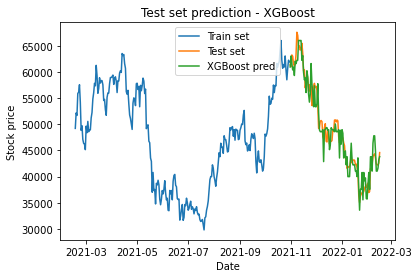

In [12]:
# Plotting the prediction results on the test set

plt.title("Test set prediction - XGBoost")
plt.xlabel("Date")
plt.ylabel("Stock price")

plt.plot(train_xgb.index, train_xgb.Close,label="Train set")
plt.plot(test_xgb.index, test_xgb.Close, label="Test set")
plt.plot(test_xgb.index, pred_xgb, label="XGBoost pred")

plt.legend()

plt.show()

## Forecast

In [13]:
## Creating the dates for the forecast
last_date = df.index[-1]
pred_dates = pd.date_range(last_date, periods=100).tolist()

In [14]:
## Convert the pred_xgb series to a 2D array
pred_xgb = np.array(pred_xgb).reshape(-1,1)

## Taking the last value of the array and predict the next one
current_pred = model_xgb.predict(pred_xgb[[-1]])

## Collecting the preds in a list
final_pred_xgb = []

final_pred_xgb.append([current_pred])

In [15]:
## Making the predicition for the next 100 days by a for loop with the prior method
## Already had the first element in the final_pred_xgb list, so the range is 99
for i in range(99):
    
    current_pred = model_xgb.predict(final_pred_xgb[-1])
    
    final_pred_xgb.append([current_pred])

In [16]:
## Convert our predicition back to a 2D array
final_pred_xgb = np.array(final_pred_xgb).reshape(-1,1)

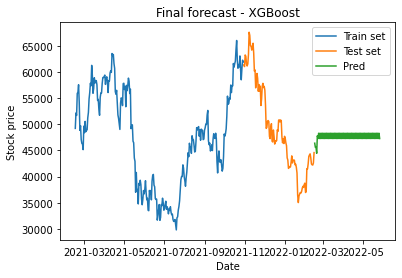

In [17]:
## Plotting our predicitions for the next 100 days
plt.title("Final forecast - XGBoost")
plt.xlabel("Date")
plt.ylabel("Stock price")

plt.plot(train_xgb.index, train_xgb.Close, label="Train set")
plt.plot(test_xgb.index, test_xgb.Close, label="Test set")
plt.plot(pred_dates, final_pred_xgb, label="Pred")

plt.legend()

plt.show()

## Increasing n_estimator

As the number of the trees reach 1148, the forecast values are starting to copy the last 83 values of the training set. After the train set comes over the model can not predict further and drawns a same cyclical pattern like in the previous predicition with lower n_estimators. 

Increasing the number of trees does not have any significant impact on RMSE and MAPE.

In [18]:
def bigger_est(est):    
    model_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=est, max_depth=8, learning_rate=0.1)
    
    model_xgb.fit(X_train, y_train)
    
    pred_test_xgb = model_xgb.predict(X_test)
    
    rmse_test_xgb = mean_squared_error(y_test, pred_test_xgb, squared=False)
    mape_test_xbg = mean_absolute_percentage_error(y_test, pred_test_xgb)
    
    pred_test_xgb = np.array(pred_test_xgb).reshape(-1,1)

    current_pred = model_xgb.predict(pred_test_xgb[[-1]])

    final_testpred_xgb = []

    final_testpred_xgb.append([current_pred])
    
    for i in range(99):
    
        current_pred = model_xgb.predict(final_testpred_xgb[-1])
    
        final_testpred_xgb.append([current_pred])
    
    final_testpred_xgb = np.array(final_testpred_xgb).reshape(-1,1)
    
    print("RMSE:",round(rmse_test_xgb,2))
    print("MAPE:",round(mape_test_xbg*100,2),"%")
    
    plt.figure(figsize=(12,5))
    plt.title("Comparing train set and forecast(n_estimator={})".format(est), pad=20, fontsize=15)
    plt.xlabel("Date", labelpad=20, fontsize=12)
    plt.ylabel("Stock price", labelpad=20, fontsize=12)
    
    plt.plot(train_xgb.index[-83:], train_xgb.Close[-83:])
    plt.plot(test_xgb.index, test_xgb.Close, alpha=0.2)
    plt.plot(pred_dates, final_testpred_xgb)
    
    plt.legend(["Train set last 83 prices","Test set","Forecast for the next 100 days with 10e trees"], ncol=3, loc="upper center", bbox_to_anchor=(0.5,-0.25),frameon=False, fontsize=12)

RMSE: 2598.51
MAPE: 4.35 %


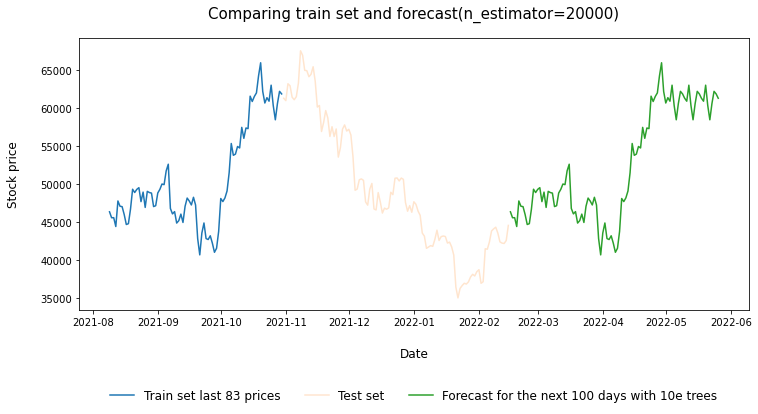

In [19]:
bigger_est(20000)